In [ ]:
!pip install torch
!pip install torchvision
!pip install Pillow
! pip install git+https://github.com/openai/CLIP.git
!pip install dnnlib
!pip install click
!pip install matplotlib
!pip install ninja

# StyleGan2 and CLIP models loading

In [17]:
import clip
import dnnlib
import legacy
import torch 
import torchvision
import math
from torchvision.utils import make_grid
import PIL 
import matplotlib.pyplot as plt

def load_models():
    # Load clip model
    clip_model, clip_preprocess = clip.load("ViT-B/32")
    clip_model.eval()
    clip_preprocess = torchvision.transforms.Compose([clip_preprocess.transforms[0],
                                                      clip_preprocess.transforms[1],
                                                      clip_preprocess.transforms[4],])
    # Load style-gan2 model trained on FFHQ dataset
    network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl'
    with dnnlib.util.open_url(network_pkl) as f:
        stylegan2_model = legacy.load_network_pkl(f)['G_ema'] # type: ignore
        stylegan2_model.eval()
    return stylegan2_model, clip_model, clip_preprocess


# Parametric Gaussian Distribution module for learning embedding distribution 

In [4]:
class GaussianDistribution(torch.nn.Module):
  def __init__(self, z_dim, mean=0.0, log_std=-4.0):
    super(GaussianDistribution, self).__init__()
    
    self.mean_latent = torch.nn.Parameter(torch.ones(stylegan2_model.z_dim)*mean,requires_grad=True)
    # initialize log standard deviation to small value for faster convergence rate udring optimization ( sacrificing diversity)
    self.log_std_latent = torch.nn.Parameter(torch.ones(stylegan2_model.z_dim)*log_std,requires_grad=True)

  def log_prob(self, z):
    n_samples = z.shape[0]
    mean = self.mean_latent.unsqueeze(0).repeat(n_samples,1)
    log_std = self.log_std_latent.unsqueeze(0).repeat(n_samples,1)
    return -0.5 * ((z - mean) / torch.exp(log_std)) ** 2 - log_std - math.log(math.sqrt(2 * math.pi))

  def sample(self, n_samples):
    log_std = self.log_std_latent.unsqueeze(0).repeat(n_samples,1)
    mean = self.mean_latent.unsqueeze(0).repeat(n_samples,1)
    return mean + torch.exp(log_std) * torch.randn_like(mean)

# Text2EmbeddingDistribution gradient-free optimization process

In [3]:
def description2image_optimization(textual_description, 
                                  latent_distribution,
                                      clip_model, 
                                      clip_preprocess, 
                                      stylegan_model,
                                      num_optimization_steps=1000,
                                      img_batch_size=12,
                                      learning_rate=1e-2,
                                      use_cuda = True):
    if(use_cuda):
      stylegan_model.cuda()
      clip_model.cuda()
                          
    # Get textual description embedding
    with torch.no_grad():
      text_tokens = clip.tokenize([textual_description])
      if(use_cuda):
        text_tokens = text_tokens.cuda()
      textual_description_embedding = clip_model.encode_text(text_tokens).float()

    # Initialize latent learned latent distribution
    if(use_cuda):
      latent_distribution = latent_distribution.cuda()
    
    # Optimization
    optimizer = torch.optim.Adam(latent_distribution.parameters(), lr=learning_rate)
    for step in range(0,num_optimization_steps):
      optimizer.zero_grad()                                                                          
      # Generate images with style gan from learned distribution
      with torch.no_grad():
        z = latent_distribution.sample(img_batch_size)
        label_embedding = torch.zeros((img_batch_size, stylegan2_model.c_dim))
        if(use_cuda):
          z = z.cuda()
          label_embedding = label_embedding.cuda()
        gen_imgs = stylegan_model(z, label_embedding, truncation_psi=1, noise_mode='random')
        # Preprocess images for clip
        clip_imgs = (gen_imgs*0.5+1.0).clamp(0.0,1.0)
        clip_imgs = clip_preprocess(clip_imgs)
        
        # Get  embeddings from generated images
        image_embeddings = clip_model.encode_image(clip_imgs)

        # Compute embedding similarity
        embeddings_similarity = torch.cosine_similarity(textual_description_embedding,
                                                       image_embeddings)

      # Optimize latent vector distribution to  
      latent_log_prob = latent_distribution.log_prob(z).mean(dim=1)
      loss = -latent_log_prob*embeddings_similarity
      loss = loss.mean()
      loss.backward()
      optimizer.step()
      if(step%10==0):
        print("Step: {}, Loss: {}, Embeddings Similiarity: {}".format(step, 
                                                        loss.item(), 
                                                        embeddings_similarity.mean().item()))

In [8]:
import warnings
warnings.filterwarnings('ignore')

use_cuda= True    
description = 'Blonde male wearing sunglasses and lipstick.'
stylegan2_model, clip_model, clip_preprocess = load_models()
latent_distribution = GaussianDistribution(stylegan2_model.z_dim)
z= latent_distribution.sample(40)
print(z.shape)
print(type(z))

# description2image_optimization(description, latent_distribution, clip_model, clip_preprocess, stylegan2_model, use_cuda=use_cuda)

No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.1'


torch.Size([40, 512])
<class 'torch.Tensor'>


# Visualizing Generated images from learned distribution representing the textual description

In [10]:
class MLP(torch.nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim=256, n_hidden=3):
    super(MLP, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.n_hidden = n_hidden
    self.layers = torch.nn.ModuleList()
    self.layers.append(torch.nn.Linear(self.input_dim, self.hidden_dim))
    for i in range(self.n_hidden):
      self.layers.append(torch.nn.Linear(self.hidden_dim, self.hidden_dim))
    self.layers.append(torch.nn.Linear(self.hidden_dim, self.output_dim))

    # 1- cosine similarity loss
    self.loss = torch.nn.CosineSimilarity(dim=-1)
  # def forward(self, x):
    
  #   x = x.float()
  #   for i in range(len(self.layers)):
  #     x = self.layers[i](x)
      
  #     if(i < len(self.layers)-1):
  #       x = torch.nn.functional.relu(x)
        
  #   return x
  def forward(self, x):
    x = x.float()
    for i in range(len(self.layers)):
      x = self.layers[i](x)
      if(i < len(self.layers)-1):
        x = torch.nn.functional.relu(x)
      else:
        x = torch.nn.functional.tanh(x)
    return x

  def backward(self, clip, latent):
    y_pred = self.forward(clip)
    loss=self.loss(y_pred, latent)
   
    return 1-loss.mean()

In [6]:
class Decoder(torch.nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.layer1 = torch.nn.Linear(64,128)
    self.layer2 = torch.nn.Linear(128,256)
    self.layer3 = torch.nn.Linear(256,512)

  def forward(self,x):
      out = self.layer1(x)
      out = self.layer2(out)
      return self.layer3(out)
  
class Encoder(torch.nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.layer1 = torch.nn.Linear(512,256)
    self.layer2 = torch.nn.Linear(256,128)
    self.layer3 = torch.nn.Linear(128, 64)
  
  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    return self.layer3(out)

In [7]:
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path_decoders = os.getcwd().replace("\\", "/") +"/"
clip_encoder = Encoder()
clip_encoder.load_state_dict(torch.load(path_decoders + "clip_encoder.pt"))
clip_encoder.to(device)
clip_encoder.eval()
latent_decoder = Decoder()
latent_decoder.load_state_dict(torch.load(path_decoders + "latent_decoder.pt"))
latent_decoder.to(device)
latent_decoder.eval()


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [19]:
stylegan2_model, clip_model, clip_preprocess = load_models()

No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.1'


In [13]:
# #download the model clip_to_latent.pt
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# mlp = MLP(64, 64,hidden_dim=256,n_hidden=1).to(device)
# state_dict = torch.load('clip_to_latent_64_encode.pt')
# mlp.load_state_dict(state_dict)
# mlp.eval()



# textual_description= "A chinese"
# # Get textual description embedding
# with torch.no_grad():
#     text_tokens = clip.tokenize([textual_description])
    
#     text_tokens = text_tokens.to(device)
#     textual_description_embedding = clip_model.encode_text(text_tokens).float()
#     # predictions = mlp.forward(textual_description_embedding)
#     predictions = mlp.forward(clip_encoder.forward(textual_description_embedding))



# print(type(predictions))
# print(predictions.shape)

# predictions = latent_decoder(predictions)

# print(type(predictions))
# print(predictions.shape)

# predictions = predictions.squeeze().cpu()

# latent_distribution_pepesito = GaussianDistribution(stylegan2_model.z_dim,mean=predictions,log_std=-2.0)



RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [48]:
#download the model clip_to_latent.pt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp = MLP(512, 512,hidden_dim=256,n_hidden=1).to(device)
state_dict = torch.load('MLP_512_cpu.pt')
mlp.load_state_dict(state_dict)
mlp.eval()



textual_description= "A chinese man with a hat"
# Get textual description embedding
with torch.no_grad():
    text_tokens = clip.tokenize([textual_description])
    
    text_tokens = text_tokens.to(device)
    textual_description_embedding = clip_model.encode_text(text_tokens).float()
    # predictions = mlp.forward(textual_description_embedding)
    predictions = mlp.forward(textual_description_embedding)



print(type(predictions))
print(predictions.shape)

# predictions = latent_decoder(predictions)

print(type(predictions))
print(predictions.shape)

predictions = predictions.squeeze().cpu()

latent_distribution_512 = GaussianDistribution(stylegan2_model.z_dim,mean=predictions,log_std=-2.0)


<class 'torch.Tensor'>
torch.Size([1, 512])
<class 'torch.Tensor'>
torch.Size([1, 512])


(-0.5, 2053.5, 2053.5, -0.5)

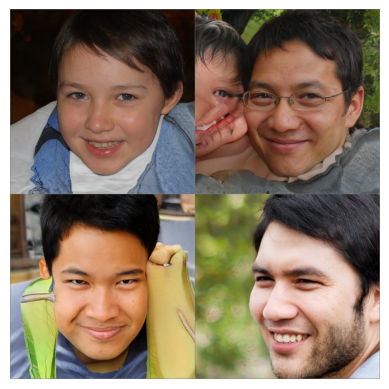

In [49]:
from torchvision.utils import make_grid
import PIL 
import matplotlib.pyplot as plt
import warnings
import numpy as np
import random
warnings.filterwarnings('ignore')
# mean= [1.0]*int(stylegan2_model.z_dim/2) + [-1.0]*int(stylegan2_model.z_dim/2)
# mean = torch.tensor(mean)

# print(mean)

# print(type(mean))
# print(mean.shape)

# latent_distribution_pepesito = GaussianDistribution(stylegan2_model.z_dim,mean=-1,log_std=-2.0)

use_cuda  = False
n_images = 4
with torch.no_grad():
    z = latent_distribution_512.sample(n_images)
    label_embedding = torch.zeros((n_images, stylegan2_model.c_dim))
    if(use_cuda):
        z = z.cuda()
        label_embedding = label_embedding.cuda()
        stylegan2_model.cuda()
        clip_model.cuda()
        gen_imgs = stylegan2_model(z, label_embedding, truncation_psi=1, noise_mode='random')
    else:
        z = z.cpu()
        label_embedding = label_embedding.cpu()
        stylegan2_model.float()
       
        clip_model.cpu()
        gen_imgs = stylegan2_model(z, label_embedding, truncation_psi=1, noise_mode='random',force_fp32=True)

grid_image = make_grid(gen_imgs, nrow=2)
grid_image = (grid_image.permute(1, 2, 0) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
pil_image=PIL.Image.fromarray(grid_image.cpu().numpy(), 'RGB')
plt.imshow(pil_image)
plt.axis('off')


In [1]:

#torch version

torch.float32

In [6]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    #get to know the type of image_features
    print(type(image_features))
    print(image_features.shape)

    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

<class 'torch.Tensor'>
torch.Size([1, 512])
Label probs: [[0.9927937  0.00421067 0.00299573]]
